# Preparations

### Fetch Packages and Files

In [9]:
# Fetch the required julia packages (packages can be added by "> using Pkg, Pkg.add("PackageName")").
using DiffEqBase
using DiffEqJump
using Plots
using Plots.Measures
using Serialization
using Statistics
gr(); default(fmt = :png);

In [10]:
# Loads the files with the required functions for this project.
include("Functions/sigV_model.jl")     # This file declares the model.
include("Functions/simulate.jl")       # This fule contains the functions for simulating the model.
include("Functions/make_plots.jl");    # This file contains the function for creating the plots.
include("Functions/make_csvs.jl");     # This file contains the function for re-saving simulations as csv files (if one wishes to access them from other programming langauges).

### Sets File Destination

In [11]:
# Sets folder where the simulations are saved.
data_folder = "../Data/";

In [4]:
# Sets folder where the figures are saved.
figure_folder = "../Figures/"; 

### Set Parameters

In [5]:
v0 = 0.1; v = 2.5; K = 60; n = 2;
kD = 5; kB = 10; kC = 0.05;
deg = 0.01; L = 0.; 
p = [v0,v,K,n,kD,kB,kC,deg,L];

# Analysis

In [6]:
m = 100;
l = 4000.;

 16.204197 seconds (7.31 M allocations: 424.634 MiB, 0.88% gc time)


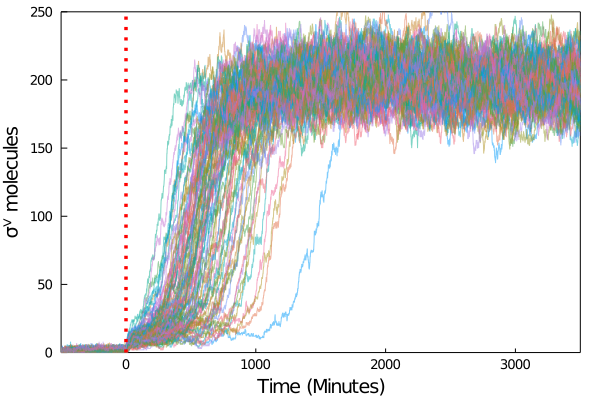

In [7]:
# Simulates the wildtype activation (for reference).
@time sols_WT = ssa_monte(p,(-500.,l-500.),m,((0.,1.),));
serialize(data_folder*"parameter_perturbations/wt_activation.jls",sols_WT)
plot_sims(sols_WT,ylimit=(0,250)); plot_WT_activation = plot_stress_pattern!([0],[],250)

In [14]:
# Makes simulations of the activation for various amounts of perturbation.
parameters_perturbed_sols = Matrix{Any}(undef,8,2)
for (i,p_idx) in enumerate([1,2,3,4,5,6,7,8])
    for (j,perturb) in enumerate([0.9,1.10])
        this_p = setindex!(deepcopy(p),p[p_idx]*perturb,p_idx)
        serialize(data_folder*"parameter_perturbations/parameters_perturbed_activation_paramNbr_$(i)_val_$(j).jls",ssa_monte(this_p,(-500.,l-500.),m,((0.,1.),)))
    end
end

In [15]:
# Feteches the data of the activations for perturbed parameters (if one so wishes).
sols_WT = deserialize(data_folder*"parameter_perturbations/wt_activation.jls")
parameters_perturbed_sols = [deserialize(data_folder*"parameter_perturbations/parameters_perturbed_activation_paramNbr_$(i)_val_$(j).jls") for i in 1:8, j in 1:2];

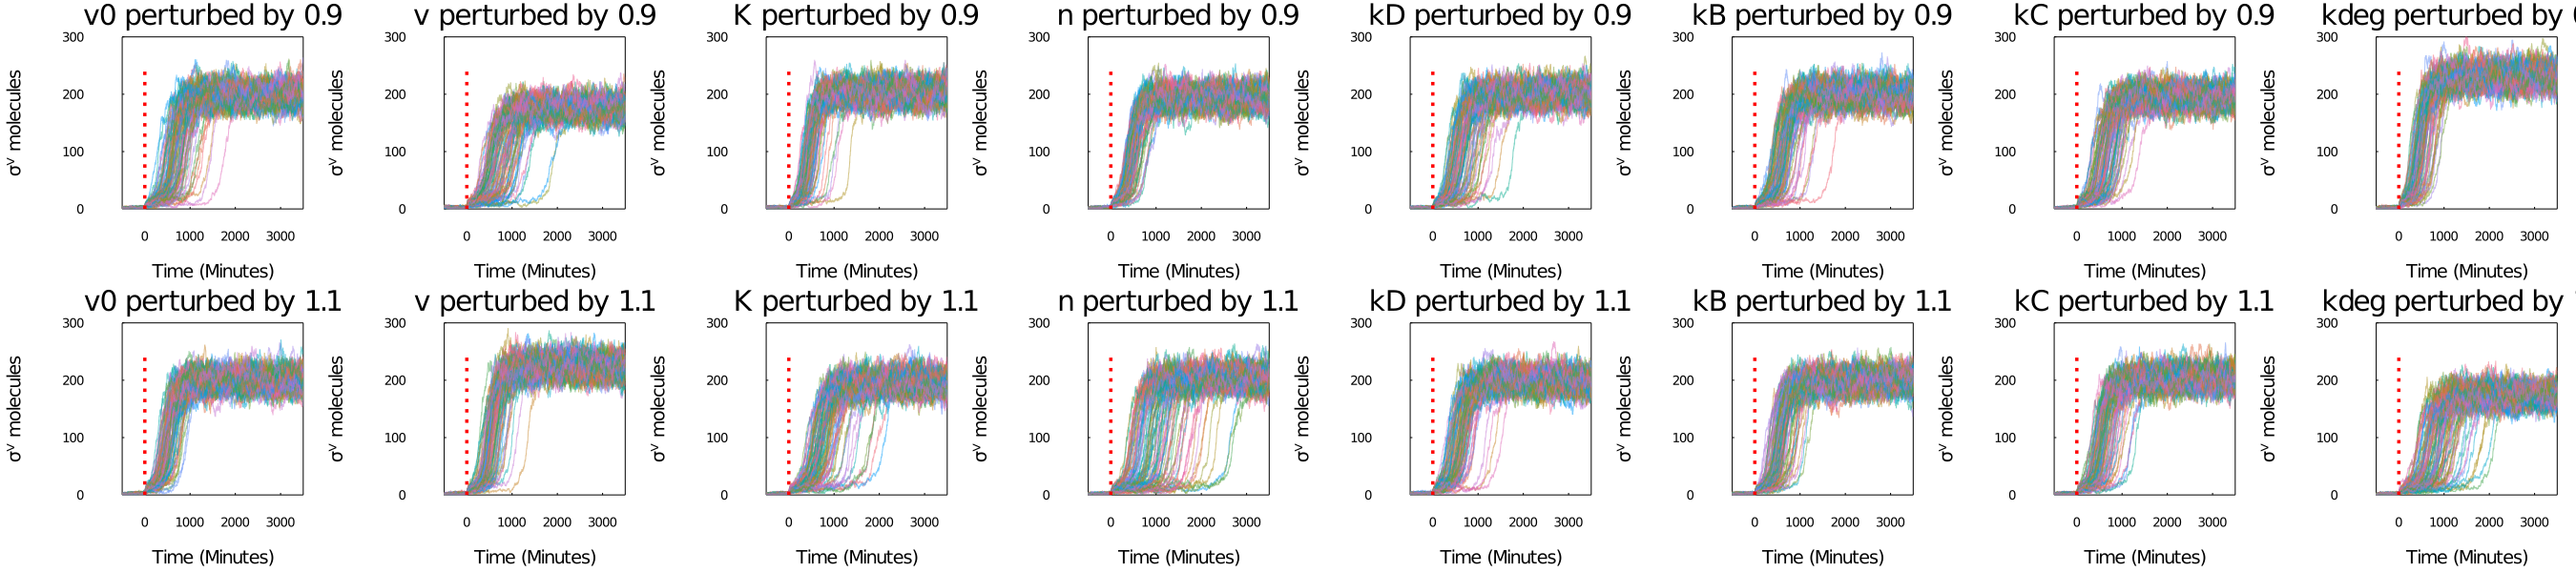

In [16]:
# Makes plots of the activation as the various parameters are modulated +/- 10%.
p_names = ["v0","v","K", "n", "kD","kB","kC","kdeg"]
activation_parameters_perturbated_plots = Matrix{Any}(undef,8,2)
for (i,p_idx) in enumerate([1,2,3,4,5,6,7,8])
    for (j,perturb) in enumerate([0.9,1.10])
        plot_sims(parameters_perturbed_sols[i,j],ylimit=(0,300),title = "$(p_names[i]) perturbed by $(perturb)",bottom_margin=5mm)
        activation_parameters_perturbated_plots[i,j] = plot_stress_pattern!([0],[],250); 
    end
end
activation_parameters_perturbated_plot = plot(activation_parameters_perturbated_plots...,size=(2700,600),layout=(2,8),bottom_margin=13mm,top_margin=5mm,left_margin=15mm)

In [17]:
# Calculate the cummulative activation trajectories for each case.
cum_wt = mean(on_value.(first.(hcat(getfield.(sols_WT,:u)...)),30,75),dims=2)
cums = map(sol -> mean(on_value.(first.(hcat(getfield.(sol,:u)...)),30,75),dims=2), parameters_perturbed_sols);

In [18]:
# makes plots of the cummulative fraction of activated cells for the various parameter perturbations.
cplots = Vector{Any}(undef,8)
for i = 1:8
    plot([0.,0.],[-0.05,1.05],linestyle=:dot,color=:black,lw=2.5,label="")
    plot!(sols_WT[1].t,cums[i,2],label="Perturbation by 1.1",framestyle=:box,xguide="Time (Minutes)",yguide="Fraction of active cells",legend=:bottomright,xlimit=(-500.,2500.),color=palette(:default)[3],linealpha=1.,lw=2) 
    plot!(sols_WT[1].t,cums[i,1],label="Perturbation by 0.9",color=palette(:default)[2],linealpha=1.,lw=2)
    cplots[i] = plot!(sols_WT[1].t,cum_wt,label="Wildtype Activation",title="Perturbation of $(p_names[i])",color=palette(:default)[1],grid=false,guidefontsize=13,legendfontsize=11,linealpha=1.,lw=2,ylimit=(-0.03,1.03))   
end

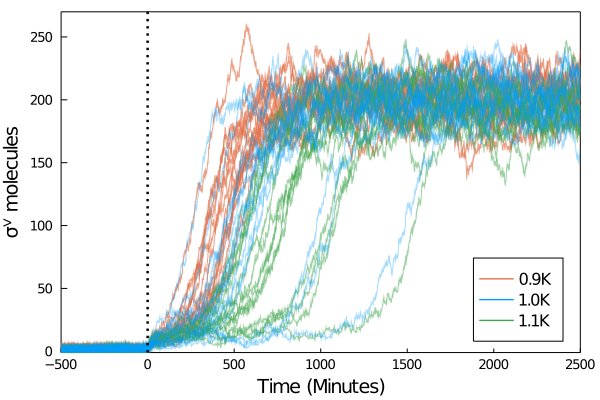

In [19]:
# Makes a plot of the WT activation, as well as activation with the "K" parameter perturbed +/- 10%.
plot_sims(parameters_perturbed_sols[3,1][1:15],color=palette(:default)[2],linealpha=0.65)
plot_sims!(parameters_perturbed_sols[3,2][1:15],color=palette(:default)[3],linealpha=0.50)
plot_sims!(sols_WT[1:15],color=palette(:default)[1],linealpha=0.35)
plot!([],[],color=palette(:default)[2],label="0.9K")
plot!([],[],color=palette(:default)[1],label="1.0K")
plot!([],[],color=palette(:default)[3],label="1.1K",legend=:bottomright,legendfontsize=11)
activation_K_Perturbed_plot = plot!([0.,0.],[-1,270],linestyle=:dot,color=:black,lw=2.5,label="",ylimit=(-1,270.),xlimit=(-500.,2500.))

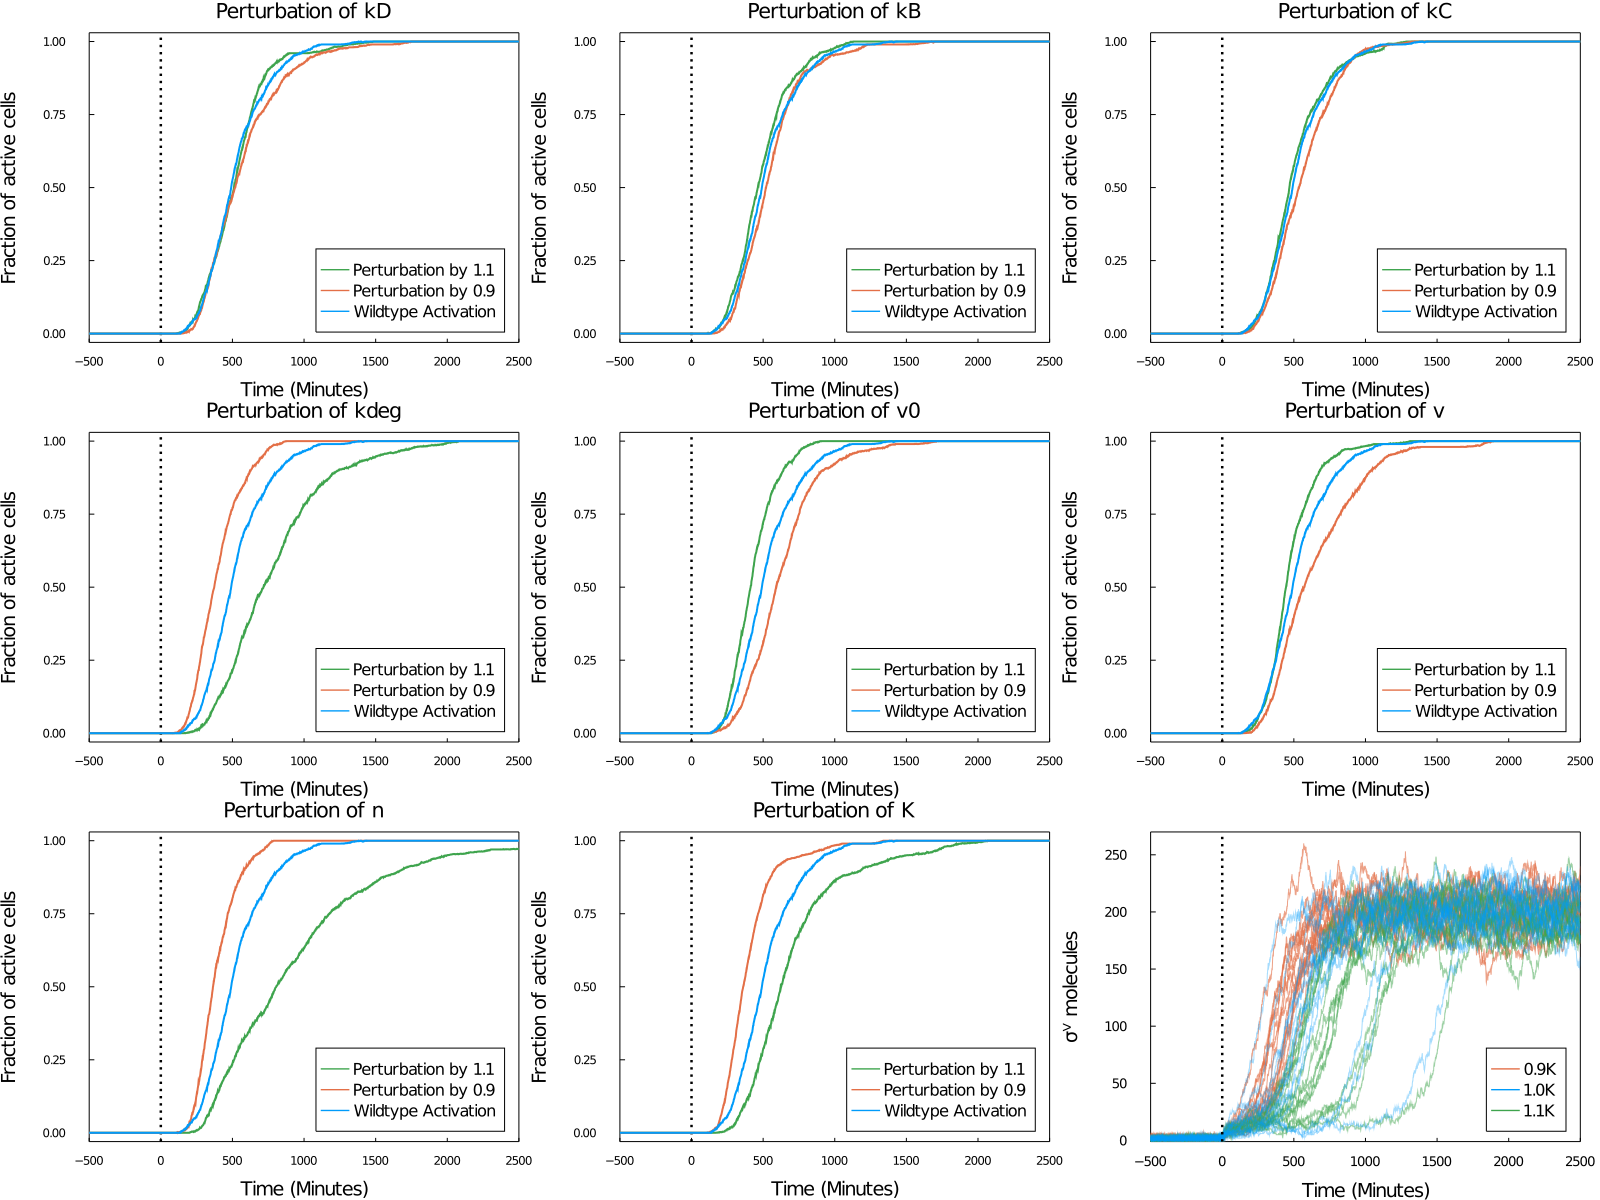

In [20]:
parameter_perturbation_plot = plot(cplots[5],cplots[6],cplots[7],cplots[8],cplots[1],cplots[2],cplots[4],cplots[3],activation_K_Perturbed_plot,size=(1600,1200),left_margin=5mm)

In [21]:
# Saves the figures.
savefig(activation_parameters_perturbated_plot,figure_folder*"parameter_perturbations/activation_parameters_perturbated_plot.png"); savefig(activation_parameters_perturbated_plot,figure_folder*"parameter_perturbations/activation_parameters_perturbated_plot.svg");
savefig(parameter_perturbation_plot,figure_folder*"parameter_perturbations/parameter_perturbation.png"); savefig(parameter_perturbation_plot,figure_folder*"parameter_perturbations/parameter_perturbation.svg");

# Save Simulats as CSV

Since csv files can be more commonly read outside of the julia programming language, this section simply loads the simulation files, and re-saves them as csv files. The script only saves the value of the SigV variable, but this can be changed to either saving the RsiV or the SigV-RsiV variable. The csv saving function loads the target julia file from the data folder, and then resave it as csv (does not need to be in memory).

The csv files are structured as follow. Each csv file corresponds to one monte-carlo simulation from a model (all simulations drawn from the same distribution). The first line contains all of the time points. Then follows one line for each simulation (typically 100). The line contains comma-separated values with the amount of the component at that time point (the component is determined by which components are saved using the "vars" option, files have an appended "_SigV",  "_RsiV", or "_SigVRsiV", denoting which component int contains. 

In [7]:
# Selects which variable we wishes to save (and how we wish to change the file name correspondingly).
vars = [1];    # Selects for which variable we wishes to create csv files. 1 corresponds to SigV, 2 to RsiV, and 3 to SigV-RsiV. The vector can have several (e.g. for "vars = [1,2]" we would create files for both SigV and RsiV).

In [8]:
resave_as_cvs(data_folder*"parameter_perturbations/","wt_activation",vars=vars)
for i = 1:8, j = 1:2
    resave_as_cvs(data_folder*"parameter_perturbations/","parameters_perturbed_activation_paramNbr_$(i)_val_$(j)",vars=vars)
end